# Support Vector Machine (SVM) classification using Concrete-ML

 In this tutorial, we show how to create, train, and evaluate a Support Vector Machine (SVM) model using Concrete-ML library for a classification task.

It is cut in 2 parts:
1. a quick setup of a LinearSVC model with Concrete-ML
2. a more in-depth approach taking a closer look to the concrete-ml specifics


## Introduction

### Concrete-ML and useful links

> Concrete-ML is an open-source, privacy-preserving, machine learning inference framework based on fully homomorphic encryption (FHE). It enables data scientists without any prior knowledge of cryptography to automatically turn machine learning models into their FHE equivalent, using familiar APIs from Scikit-learn and PyTorch.
> 
> <cite>&mdash; [Zama documentation](../README.md)</cite>

This tutorial does not require any knowledge of Concrete-ML. Newcomers might nonetheless be interested in reading some of the introductory sections of the official documentation, such as:

- [What is Concrete-ML](../README.md)
- [Key Concepts](../getting-started/concepts.md)

### Support Vector Machine

SVM is a machine learning algorithm for classification and regression. LinearSVC is an efficient implementation of SVM
that works best when the data is linearly separable. In this tutorial, we use the [pulsar star dataset](https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate)  to determine whether a neutron star can be classified as a pulsar star.

Concrete-ML exposes a LinearSVC class which implements the
[scikit-learn LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) interface, so you should feel right at home.

### Setup code

Just as in any machine learning project, some libraries need to be imported.

In [1]:
# display visualizations and plots in the notebook itself
%matplotlib inline

# import numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC as SklearnLinearSVC

# import the concrete-ml LinearSVC implementation
from concrete.ml.sklearn.svm import LinearSVC as ConcreteLinearSVC

The following code defines a visualization function that plots the decision boundary over the 2 principal components.

In [2]:
def plot_decision_boundary(
    clf,
    X,
    y,
    title="LinearSVC Decision Boundary",
    xlabel="First Principal Component",
    ylabel="Second Principal Component",
):
    # Perform PCA to reduce the dimensionality to 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create the mesh grid
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    # Transform the mesh grid points back to the original feature space
    mesh_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])

    # Make predictions using the classifier
    Z = clf.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors="k", marker="o", s=50)

    # Calculate the accuracy
    accuracy = accuracy_score(y, clf.predict(X))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (Accuracy: {accuracy:.4f})")
    plt.show()

Import and preprocess the dataset and make some adjustments to it.

In [3]:
# Get the data
df = pd.read_csv(
    "https://gist.githubusercontent.com/robinstraub/72f1cb27829dba85f49f68210979f561/"
    "raw/b9982ae654967028f6f4010bd235d850d38fe25b/pulsar-star-dataset.csv"
)
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [4]:
# Extract the features and labels
X = df.drop(columns=["target_class"])
y = df["target_class"]

# Replace N/A values with the mean of the respective feature
X.fillna(X.mean(), inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the floating labels to integer labels for both train and test sets
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Part 1: Train a simple model with Concrete-ML

The following code quickly scaffolds a Concrete-ML LinearSVC code, which should sound familiar.


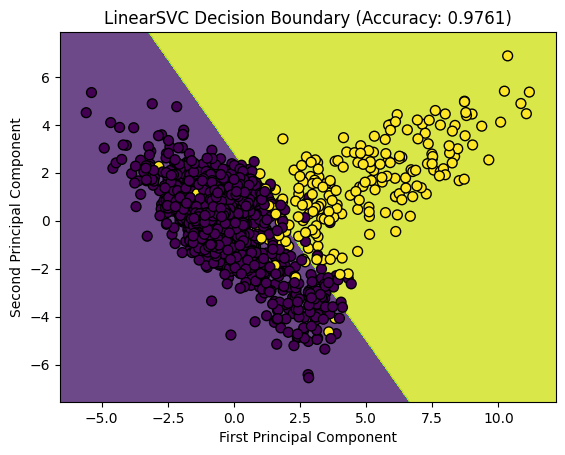

In [5]:
# Train a model with scikit-learn LinearSVC, perform prediction and compute the accuracy
svm_sklearn = SklearnLinearSVC(max_iter=100)
svm_sklearn.fit(X_train, y_train)
# plot the boundary
plot_decision_boundary(svm_sklearn, X_test, y_test)

Hopefully should not be confused by this, otherwise you may want to read the [official scikit-learn SVM documentation](https://scikit-learn.org/stable/modules/svm.html#svm-classification). 

The algorithm can be tweaked with the parameters exposed by the LinearSVC class, refer to the  [LinearSVC API documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) as to what can be customized. 

2 main components of the dataset are plotted, however do note that the latter has 8 features so this is a simplified representation.

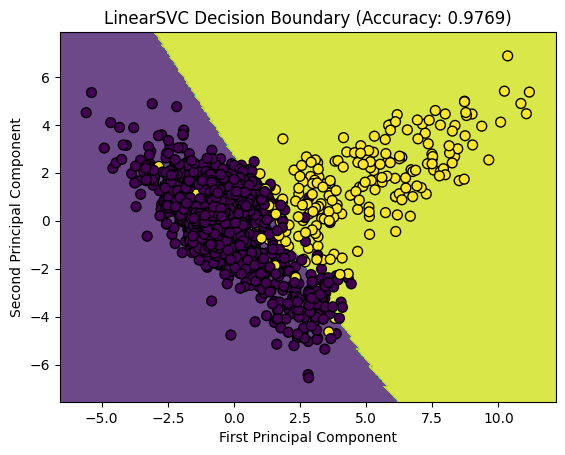

In [6]:
# Perform the same steps with the Concrete-ML LinearSVC implementation
svm_concrete = ConcreteLinearSVC(max_iter=100, n_bits=8)
svm_concrete.fit(X_train, y_train)
# plot the boundary
plot_decision_boundary(svm_concrete, X_test, y_test)

The decision boundary is not a straight line anymore and appears "noisy", which is caused by the data being quantized. The prediction remains accurate nonetheless. Here the prediction is equal to the scikit-learn implementation, however reducing the bit size can induce a drop in accuracy, as the quantization reduces the data precision.

One thing to note here is not only the model is trained using clear data, but the prediction are also performed in a *plain environment*, there is no encryption at this stage.

In order to perform prediction in an FHE environment, the model first has to be compiled into a circuit.

In [7]:
# A circuit needs to be compiled to enable FHE execution
circuit = svm_concrete.compile(X_train)
# Now that a circuit is compiled, the svm_concrete can predict value with FHE
y_pred = svm_concrete.predict(X_test, fhe="execute")
accuracy = accuracy_score(y_test, y_pred)
# print the accuracy
print(f"FHE Accuracy: {accuracy:.4f} (bit width: {circuit.graph.maximum_integer_bit_width()})")

FHE Accuracy: 0.9769 (bit width: 17)


Now that the model is compiled, computing predictions with FHE is just a matter of passing a `fhe` parameter to `execute`.

Note that the accuracy of the predictions over FHE are the same as over plain (quantized) data -- FHE execution does not alter the model accuracy.

### Key takeaways

#### Simplicity of execution

For a high-level use-case, Concrete-ML offers a very similar interface to scikit-learn. The main difference is *a model needs to be compiled to allow execution in FHE*.

#### Model Accuracy

Concrete-ML prediction accuracy can be slightly worse than a regular scikit-learn implementation. This is because of [quantization](../explanations/quantization.md): number precision needs to be fixed-size for the model to be evaluated in FHE. This can be alleviated down to where the accuracy difference is none or negligible (which is the case here with a 8 bit size).

#### Execution time

The execution speed can be slower in Concrete-ML, especially during compilation and FHE inference phases, because enabling FHE operations uses more resources than regular inference on plain data. However, the speed can be improved by decreasing the precision of the data and model's weights thanks to the n_bits parameter. But, depending on the project, there is a trade-off between a slower but more accurate model and a faster but less accurate model.

## Part 2: In-Depth model development

This is on a more in-depth approach, showing how to effectively develop with concrete-ml. This follows the steps of [model development](../getting-started/concepts.md#i.-model-development)

Especially:
- the effects of quantization and finding the good bit number
- setup the fhe simulation to speed up the development workflow
- use inference to use the model with encrypted data

---

### Step a: training the model

Nothing new under the sun here, a relevant model needs to be trained for this machine-learning problem. We can just take back what we used so far.

In [8]:
# setup and train a scikit-learn LinearSVC model, just as before
svm_sklearn = SklearnLinearSVC()
svm_sklearn.fit(X_train, y_train)
# predict some test data and measure the model accuracy
y_pred_sklearn = svm_sklearn.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print(f"Scikit-learn Accuracy: {accuracy_sklearn:.4f}")

Scikit-learn Accuracy: 0.9769


Not too shabby.

### Step b: quantize the model

So far most of Concrete-ML specificities have conveniently been avoided for the sake of simplicity. The first Concrete-ML specific step of developping a model is to quantize it, which soberly means to turn the model into an integer equivalent.

Although it is strongly encouraged to read the [Zama introduction to quantization](../explanations/quantization.md), the key takeaway is **a model needs to be reduced to a *discrete*, smaller set in order for the encryption to happen**. Otherwise the data becomes too large to be manipulated in FHE. 

As of v1.0 the maximum bit size is 16. The lighter the bit size the more efficient the concrete-ml model is. Thus the goal of the quantization step is to find the lowest bit size value that offers an acceptable accuracy, so the model efficiency is maximized.

We can see that the accuracy increase with the bit size, although it remains quite good even for lower bit sizes.

Let's work on a more objective way of selecting the best n_bit parameter alongside some common parameters for LinearSVC

In [9]:
svm = ConcreteLinearSVC()

# Define the parameter grid for the grid search
param_grid = param_grid = [
    {
        "C": np.logspace(-3, 3, 7),
        "n_bits": range(2, 17),
        "penalty": ["l1", "l2"],
        "dual": [False, True],
    },
]

# Use the F1 score as the metric to optimize, as it provides a
# balanced trade-off between precision and recall
scorer = make_scorer(f1_score, average="weighted")

# Set up the grid search with the custom scoring function
grid_search = GridSearchCV(svm, param_grid, scoring=scorer, cv=5, n_jobs=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Convert the grid search results into a pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Define a custom function to highlight a specific row based on n_bits value


def highlight_row(row, n_bits_value=3, color="green"):
    return [
        f"background-color: {color}" if row["param_n_bits"] == n_bits_value else "" for _ in row
    ]


# Find the best hyperparameter combination for each n_bits value
best_results = results_df.loc[results_df.groupby("param_n_bits")["mean_test_score"].idxmax()]
best_results = best_results[
    ["param_n_bits", "param_C", "param_penalty", "param_dual", "mean_test_score"]
]
best_results.reset_index(drop=True, inplace=True)

# Display the best results DataFrame
best_results.style.apply(highlight_row, n_bits_value=3, axis=1).hide()

param_n_bits,param_C,param_penalty,param_dual,mean_test_score
2,0.001000,l2,False,0.945603
3,1.000000,l1,False,0.971102
4,0.010000,l2,False,0.970423
5,10.000000,l1,False,0.973795
6,10.000000,l2,True,0.973070
7,1.000000,l1,False,0.972945
8,10.000000,l2,True,0.973313
9,10.000000,l2,True,0.972931
10,100.000000,l2,True,0.973866
11,10.000000,l2,True,0.973302


Here, n_bits = 3 is the best compromise between latency and performance.

### Step c: simulate the model execution

Executing models with FHE can prove to be a slow process, depending on:
- the data-set size
- the model itself
- the hardware executing the model

Setting up a model in Concrete-ML requires some additional work compared to standard models. For instance, users must select the quantization bit-width for both the model's weight and input data, which can be complex and time-consuming while using real FHE inference. However, Concrete-ML provides an FHE simulation mode that allows users to identify optimal hyper-parameters with the best trade-off between latency and performance.

> Testing FHE models on very large data-sets can take a long time. Furthermore, not all models are compatible with FHE constraints out-of-the-box. Simulation using the FHE simulation allows you to execute a model that was quantized, to measure the accuracy it would have in FHE, but also to determine the modifications required to make it FHE compatible.
>
> — [Zama documentation](../getting-started/concepts.md#i.-model-development)


In [10]:
svm_concrete = ConcreteLinearSVC(n_bits=3, C=1, dual=False, penalty="l1")
svm_concrete.fit(X_train, y_train)

# compile the model
circuit = svm_concrete.compile(X_train)

# the model can now be executed with FHE
y_pred = svm_concrete.predict(X_test, fhe="simulate")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with FHE simulation: {accuracy:.4f}")

Accuracy with FHE simulation: 0.9745


*The FHE simulation enables some unsafe features, so it should understandably not be used for production*

So far so good, the model is compiled and executed much quicker with the virtual library, allowing us to run it more efficiently in development environments.

### Step d: compile the model

Now that we have selected a relevant bit size and parameters we can compile the model, with FHE execution instead of FHE simulation, so we can use it in production

In [11]:
# predict the test set to verify the compiled model accuracy
y_pred = svm_concrete.predict(X_test, fhe="execute")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with FHE execution: {accuracy:.4f}")

Accuracy with FHE execution: 0.9745


## Conclusion

Setting up FHE with Concrete-ML on a LinearSVC model is very simple, in the regard that Concrete-ML provides an implementation of the [scikit-learn LinearSVC interface](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). As a matter of fact, a working FHE model can be setup with just a few lines of code.

Setting up a model with FHE benefits nonetheless from some additional work. For LinearSVC models, the main point is to select a relevant bit-size for [quantizing](../explanations/quantization.md) the model. Some additional tools can smooth up the development workflow, such as alleviating the [compilation](../explanations/compilation.md) time by making use of the [FHE simulation](../explanations/compilation.md#fhe-simulation) 

Once the model is carefully trained and quantized, it is ready to be deployed and used in production. Here are some useful links that cover this subject:
- [Inference in the Cloud](../getting-started/cloud.md) summarize the steps for cloud deployment
- [Production Deployment](../guides/client_server.md) offers a high-level view of how to deploy a Concrete-ML model in a client/server setting.
- [Client Server in Concrete ML](ClientServer.ipynb) provides a more hands-on approach as another tutorial.